# Basic CNN Model - Log-Mel Spectrograms

To compare the results from the previous notebook between MFCC and Log-Mel Spectrograms features I'm going to replicate the same basic CNN model training procedure of that notebook.


#### * Load required libraries

In [2]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#### Setup

In [3]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

####  Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Mel Spectrogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.<br/>
<br/>

In [5]:
# Pre-processed Spectro coefficients
X = np.load("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/extracted_features/X-mel_spec-augmented.npy")
y = np.load("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/extracted_features/y-mel_spec-augmented.npy")

# Metadata
metadata = pd.read_csv("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head(3)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing


###  Data preparation: features + metadata

#### Train / Test split
Note that we are using the same index order for both the Mel Spectrogram arrays and the metadata to keep track of the origin of each feature

In [6]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### One hot encode labels

In [7]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### Reshape data

In [8]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [9]:
# Class distribution
metadata['class'].value_counts()

drilling            1000
engine_idling       1000
children_playing    1000
dog_bark            1000
street_music        1000
jackhammer          1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

Check PCA benefits

Text(0, 0.5, 'Variance (%)')

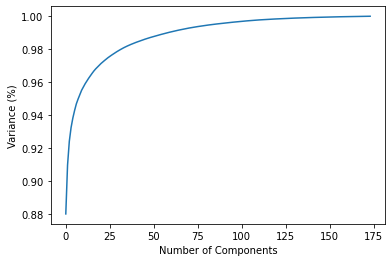

In [10]:
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

##  Basic CNN network

We are using the exact same architecture than the previous notebook.
<br/>

#### Model definition



In [11]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [12]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

#### Training the model

With Log-Mel Spectrograms it was possible to train for some more epochs before overfitting compared to the previous experiment with MFCC.

In [13]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/360
51/51 [==============================] - 242s 5s/step - loss: 2.0462 - accuracy: 0.2935 - val_loss: 2.3886 - val_accuracy: 0.1166

Epoch 00001: val_loss improved from inf to 2.38863, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 2/360
51/51 [==============================] - 237s 5s/step - loss: 1.8202 - accuracy: 0.3879 - val_loss: 2.5713 - val_accuracy: 0.1166

Epoch 00002: val_loss did not improve from 2.38863
Epoch 3/360
51/51 [==============================] - 241s 5s/step - loss: 1.7316 - accuracy: 0.4264 - val_loss: 2.7872 - val_accuracy: 0.1252

Epoch 00003: val_loss did not improve from 2.38863
Epoch 4/360
51/51 [==============================] - 245s 5s/step - loss: 1.6806 - accuracy: 0.4435 - val_loss: 2.9542 - val_accuracy: 0.1081

Epoch 00004: val_loss did not improve from 2.38863
Epoch 5/360
51/51 [=======================

Epoch 27/360
51/51 [==============================] - 167s 3s/step - loss: 1.2247 - accuracy: 0.6092 - val_loss: 1.1787 - val_accuracy: 0.6261

Epoch 00027: val_loss improved from 1.20491 to 1.17874, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 28/360
51/51 [==============================] - 171s 3s/step - loss: 1.2207 - accuracy: 0.6014 - val_loss: 1.1737 - val_accuracy: 0.6312

Epoch 00028: val_loss improved from 1.17874 to 1.17371, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 29/360
51/51 [==============================] - 169s 3s/step - loss: 1.2065 - accuracy: 0.6146 - val_loss: 1.1834 - val_accuracy: 0.6346

Epoch 00029: val_loss did not improve from 1.17371
Epoch 30/360
51/51 [=======================

51/51 [==============================] - 168s 3s/step - loss: 1.0447 - accuracy: 0.6775 - val_loss: 1.0198 - val_accuracy: 0.6827

Epoch 00052: val_loss did not improve from 1.00040
Epoch 53/360
51/51 [==============================] - 166s 3s/step - loss: 1.0306 - accuracy: 0.6841 - val_loss: 1.0072 - val_accuracy: 0.6861

Epoch 00053: val_loss did not improve from 1.00040
Epoch 54/360
51/51 [==============================] - 165s 3s/step - loss: 1.0244 - accuracy: 0.6841 - val_loss: 0.9951 - val_accuracy: 0.6981

Epoch 00054: val_loss improved from 1.00040 to 0.99511, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 55/360
51/51 [==============================] - 165s 3s/step - loss: 1.0140 - accuracy: 0.6908 - val_loss: 0.9947 - val_accuracy: 0.7118

Epoch 00055: val_loss improved from 0.99511 to 0.99471, saving model to C:\Users\VSBAG\Desktop\DSE

Epoch 77/360
51/51 [==============================] - 168s 3s/step - loss: 0.9153 - accuracy: 0.7334 - val_loss: 0.8886 - val_accuracy: 0.7427

Epoch 00077: val_loss improved from 0.88987 to 0.88862, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 78/360
51/51 [==============================] - 171s 3s/step - loss: 0.9080 - accuracy: 0.7333 - val_loss: 0.8951 - val_accuracy: 0.7547

Epoch 00078: val_loss did not improve from 0.88862
Epoch 79/360
51/51 [==============================] - 170s 3s/step - loss: 0.9092 - accuracy: 0.7301 - val_loss: 0.8883 - val_accuracy: 0.7496

Epoch 00079: val_loss improved from 0.88862 to 0.88828, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 80/360
51/51 [=======================


Epoch 00103: val_loss improved from 0.80574 to 0.79706, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 104/360
51/51 [==============================] - 225s 4s/step - loss: 0.8086 - accuracy: 0.7710 - val_loss: 0.8007 - val_accuracy: 0.7753

Epoch 00104: val_loss did not improve from 0.79706
Epoch 105/360
51/51 [==============================] - 228s 4s/step - loss: 0.8131 - accuracy: 0.7690 - val_loss: 0.8017 - val_accuracy: 0.7736

Epoch 00105: val_loss did not improve from 0.79706
Epoch 106/360
51/51 [==============================] - 227s 4s/step - loss: 0.8084 - accuracy: 0.7685 - val_loss: 0.7851 - val_accuracy: 0.7804

Epoch 00106: val_loss improved from 0.79706 to 0.78511, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-tra

Epoch 133/360
51/51 [==============================] - 233s 5s/step - loss: 0.7490 - accuracy: 0.7903 - val_loss: 0.7195 - val_accuracy: 0.7925

Epoch 00133: val_loss improved from 0.72282 to 0.71948, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 134/360
51/51 [==============================] - 226s 4s/step - loss: 0.7403 - accuracy: 0.7857 - val_loss: 0.7166 - val_accuracy: 0.7942

Epoch 00134: val_loss improved from 0.71948 to 0.71655, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 135/360
51/51 [==============================] - 4964s 99s/step - loss: 0.7458 - accuracy: 0.7906 - val_loss: 0.7291 - val_accuracy: 0.7976

Epoch 00135: val_loss did not improve from 0.71655
Epoch 136/360
51/51 [=================

51/51 [==============================] - 165s 3s/step - loss: 0.6201 - accuracy: 0.8309 - val_loss: 0.6320 - val_accuracy: 0.8233

Epoch 00195: val_loss did not improve from 0.61537
Epoch 196/360
51/51 [==============================] - 170s 3s/step - loss: 0.6215 - accuracy: 0.8316 - val_loss: 0.6218 - val_accuracy: 0.8285

Epoch 00196: val_loss did not improve from 0.61537
Epoch 197/360
51/51 [==============================] - 164s 3s/step - loss: 0.6176 - accuracy: 0.8240 - val_loss: 0.6257 - val_accuracy: 0.8182

Epoch 00197: val_loss did not improve from 0.61537
Epoch 198/360
51/51 [==============================] - 164s 3s/step - loss: 0.6178 - accuracy: 0.8268 - val_loss: 0.6158 - val_accuracy: 0.8268

Epoch 00198: val_loss did not improve from 0.61537
Epoch 199/360
51/51 [==============================] - 166s 3s/step - loss: 0.6141 - accuracy: 0.8310 - val_loss: 0.6252 - val_accuracy: 0.8233

Epoch 00199: val_loss did not improve from 0.61537
Epoch 200/360
51/51 [=============

51/51 [==============================] - 164s 3s/step - loss: 0.5276 - accuracy: 0.8591 - val_loss: 0.5349 - val_accuracy: 0.8439

Epoch 00260: val_loss improved from 0.53938 to 0.53494, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 261/360
51/51 [==============================] - 167s 3s/step - loss: 0.5316 - accuracy: 0.8598 - val_loss: 0.5437 - val_accuracy: 0.8370

Epoch 00261: val_loss did not improve from 0.53494
Epoch 262/360
51/51 [==============================] - 164s 3s/step - loss: 0.5334 - accuracy: 0.8566 - val_loss: 0.5327 - val_accuracy: 0.8491

Epoch 00262: val_loss improved from 0.53494 to 0.53273, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 263/360
51/51 [==============================] -

51/51 [==============================] - 235s 5s/step - loss: 0.4601 - accuracy: 0.8794 - val_loss: 0.4805 - val_accuracy: 0.8645

Epoch 00331: val_loss did not improve from 0.47912
Epoch 332/360
51/51 [==============================] - 222s 4s/step - loss: 0.4724 - accuracy: 0.8758 - val_loss: 0.4791 - val_accuracy: 0.8628

Epoch 00332: val_loss improved from 0.47912 to 0.47909, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\models\simple-train-nb3.hdf5
Epoch 333/360
51/51 [==============================] - 227s 4s/step - loss: 0.4531 - accuracy: 0.8797 - val_loss: 0.4813 - val_accuracy: 0.8611

Epoch 00333: val_loss did not improve from 0.47909
Epoch 334/360
51/51 [==============================] - 227s 4s/step - loss: 0.4502 - accuracy: 0.8846 - val_loss: 0.4841 - val_accuracy: 0.8559

Epoch 00334: val_loss did not improve from 0.47909
Epoch 335/360
51/51 [=======================

#### General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [14]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.3547       91.5259
Test:             0.4405       88.0298
Normal diff         19.46 


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.<br/>

####  Train vs Test history plot

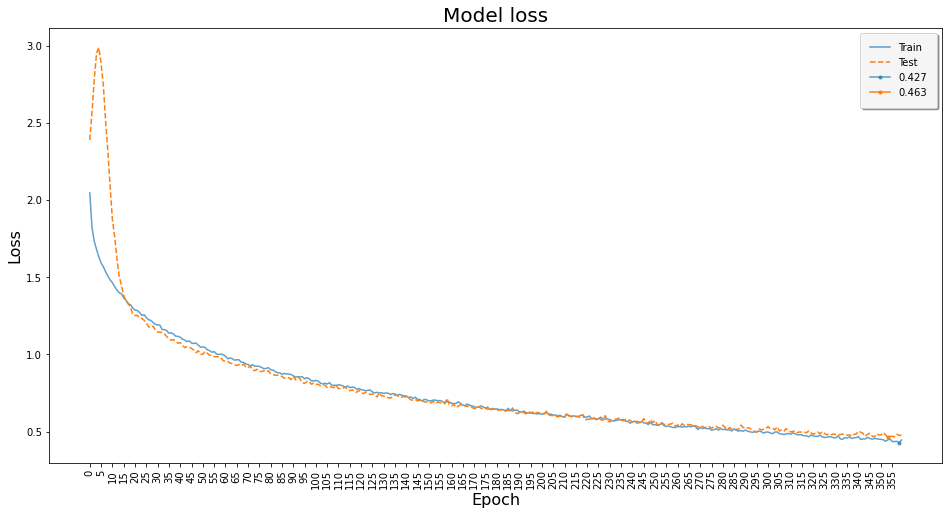

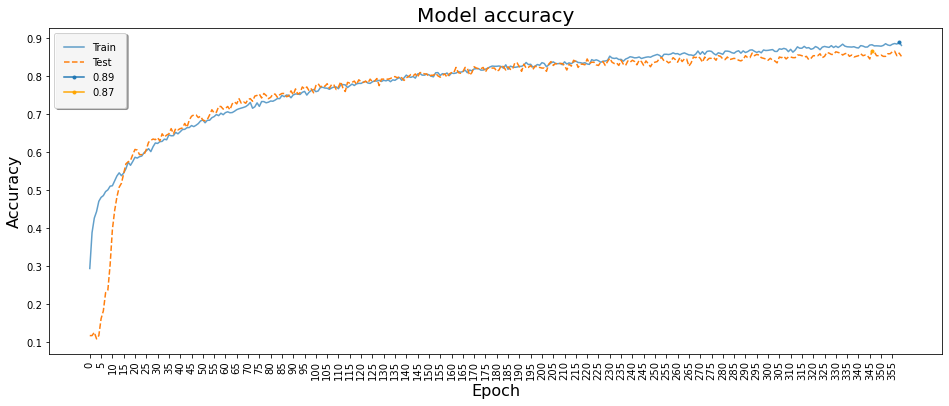

In [15]:
helpers.plot_train_history(history, x_ticks_vertical=True)

Although the shape of the curves are similar to the ones of the previous experiment, the generalization gap is thinner. If we look at the error minimums we also find out that there is a smaller difference between validation and train errors.<br/>
<br/>

###  Model evaluation


#### Register model output

In [16]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

#### Confussion matrix

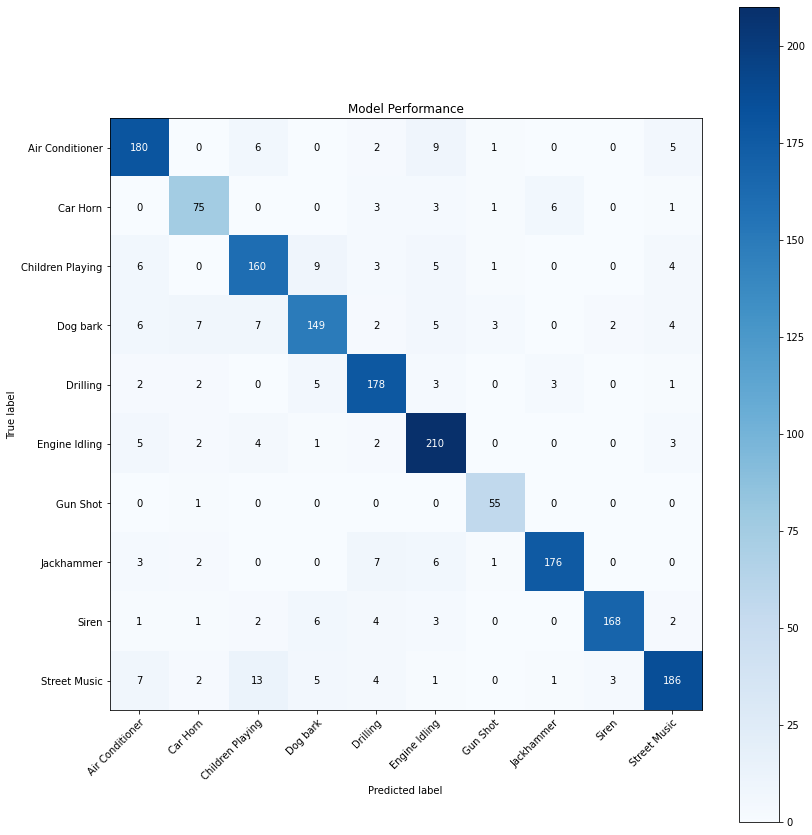

In [17]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

The patterns found on working with MFCC are replicated, but most of the true positives have increased and false negatives have decreased.<br/>
<br/>

#### Accuracy table

In [18]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,98.214286
5,Engine Idling,92.511013
4,Drilling,91.752577
7,Jackhammer,90.256410
8,Siren,89.839572
0,Air Conditioner,88.669951
2,Children Playing,85.106383
1,Car Horn,84.269663
9,Street Music,83.783784
3,Dog bark,80.540541


In a similar fashion, most class-accuracies have increased.

#### Classification performance: Presicion, Recall and F1 scores

In [19]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.86      0.89      0.87       203
        Car Horn       0.82      0.84      0.83        89
Children Playing       0.83      0.85      0.84       188
        Dog bark       0.85      0.81      0.83       185
        Drilling       0.87      0.92      0.89       194
   Engine Idling       0.86      0.93      0.89       227
        Gun Shot       0.89      0.98      0.93        56
      Jackhammer       0.95      0.90      0.92       195
           Siren       0.97      0.90      0.93       187
    Street Music       0.90      0.84      0.87       222

        accuracy                           0.88      1746
       macro avg       0.88      0.88      0.88      1746
    weighted avg       0.88      0.88      0.88      1746



Scores have increased a bit in average, we still see the same general patterns.
<br/>

Street music got the lowest Recall score: as we expected for what we saw on the confusion matrix where many class occurrences where classified as Children Playing (false negatives). Similarly, we see that many times some other class was classified as Street Music (false positive), what also lowers the Precision score for this class.

We can identify something similar with Gunshot -an unbalanced class-, where we have the lowest precision score, and if you observe the confusion matrix on the vertical axis, the model identified many other classes as Gunshot (false positives). Quite the opposite occurs on the horizontal axis: we have very little false negatives and a good Recall score for this class.

The other unbalanced class Car Horn has acceptable F1 score, just around the average, but it's a bit low in recall, again, as observed on the horizontal axis of the confusion matrix.

In general, and although we have a we can say the model is quite capable of recognizing relevant data.

# Exploring the misclassified

In [38]:
# Find the target misclassified ocurrencies
street_as_children = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 2)]

files = []
for idx, row in street_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [39]:
print("Children playing as Street music: {} ocurrencies".format(len(street_as_children)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Children playing as Street music: 13 ocurrencies

True category: street_music
File: C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\UrbanSound8K\audio/fold8/39967-9-0-0.wav


In [40]:
#Drilling as Jack Hammer
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [42]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))

Drilling as Jack Hammer: 3 ocurrencies

True category: drilling


In [43]:
# Dog Bark as Children Playing
dogbar_as_children = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 2)]

files = []
for idx, row in dogbar_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [45]:
print("Dog Bark as Children Playing: {} ocurrencies".format(len(dogbar_as_children)))
    
# Manully set the file index
index = 8
   
# Display results
print("\nTrue category: {}".format(category))

Dog Bark as Children Playing: 7 ocurrencies

True category: dog_bark


In [36]:
# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [37]:
print("Street Music as Air Conditioner: {} ocurrencies".format(len(music_as_aircon)))

# Manully set the file index
index = 2
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Street Music as Air Conditioner: 7 ocurrencies

True category: street_music
File: C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\Final_Files\Final_Model\Final_file051221\UrbanSound8K\audio/fold6/66000-9-0-2.wav
